<center> <h1 style="background-color:purple; color:white">Amazon Fine Food Reviews - EDA,<br> Data Cleaning, Data Preprocessing, Feature Engineering</h1>

## Context
This dataset consists of reviews of fine foods from amazon. The **data span** a period of more than **10 years**, including all **~500,000 reviews** up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

## Contents
Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite  
database.sqlite: Contains the table 'Reviews'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import gensim
import random
import nltk
from matplotlib import pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
from time import time
from prettytable import PrettyTable
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read csv into a dataframe

In [ ]:
connection_sqlobject = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/database.sqlite') 

In [ ]:
df = pd.read_sql_query("""SELECT * FROM Reviews """,connection_sqlobject)

#### Columns and its data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Dataset Claims

568,454 reviews  
256,059 users  
74,258 products  
260 users with > 50 reviews  
Reviews from Oct 1999 - Oct 2012  
 

In [ ]:
from prettytable import PrettyTable
import time

x = PrettyTable()
x.field_names = ["Attribute","Claim","Actual","Match"]
x.add_rows(
    [
        ["# reviews", "568454",df.shape[0],"YES"],
        ["Distinct users", "256059", df["UserId"].nunique(), "YES"],
        ["Distinct products", "74258", df["ProductId"].nunique(), "YES"],
        ["Users with more than 50 reviews", "260", (df.groupby("UserId").size()).where(lambda x:x>50).count(), "YES"],
        ["Reviews Time Range", "Oct 1999 - Oct 2012", f"{time.strftime('%b %Y', time.localtime(df['Time'].min()))} - {time.strftime('%b %Y', time.localtime(df['Time'].max()))}", "YES"]
    ]
)
print(x)

+---------------------------------+---------------------+---------------------+-------+
|            Attribute            |        Claim        |        Actual       | Match |
+---------------------------------+---------------------+---------------------+-------+
|            # reviews            |        568454       |        568454       |  YES  |
|          Distinct users         |        256059       |        256059       |  YES  |
|        Distinct products        |        74258        |        74258        |  YES  |
| Users with more than 50 reviews |         260         |         260         |  YES  |
|        Reviews Time Range       | Oct 1999 - Oct 2012 | Oct 1999 - Oct 2012 |  YES  |
+---------------------------------+---------------------+---------------------+-------+


## Attribute Information

1. **Id** - Row Id
2. **ProductId** - Unique identifier for the product
3. **UserId** - Unqiue identifier for the user
4. **ProfileName** - Profile name of the user
5. **HelpfulnessNumerator** - Number of users who found the review helpful
6. **HelpfulnessDenominator** - Number of users who indicated whether they found the review helpful or not
7. **Score** - Rating between 1 and 5
8. **Time** - Timestamp for the review
9. **Summary** - Brief summary of the review
10. **Text** - Text of the review  

<img src="https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2016/04/AmazonReview-300x189.png" width="600" height="400">

# EDA 1

In [ ]:
df_shape = df.shape
print(f"No. of Datapoints : {df_shape[0]}")
print(f"No. of Features : {df_shape[1]}")

No. of Datapoints : 568454
No. of Features : 10


## Datapoints with Missing/Null Features

In [ ]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Distribution of Ratings(Scores) across the entire dataset

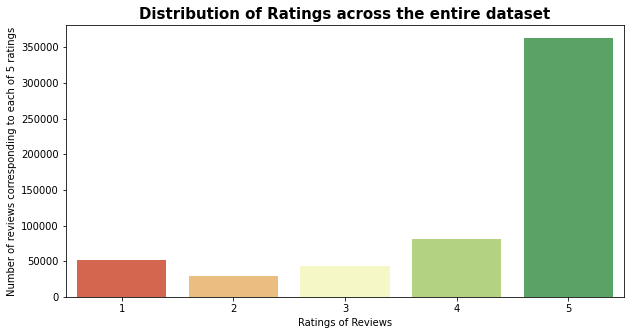



1     52268
2     29769
3     42640
4     80655
5    363122
Name: Score, dtype: int64


In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['Score'], palette=sns.color_palette("RdYlGn", 5))
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();
print('\n')
print(df['Score'].value_counts().sort_index());

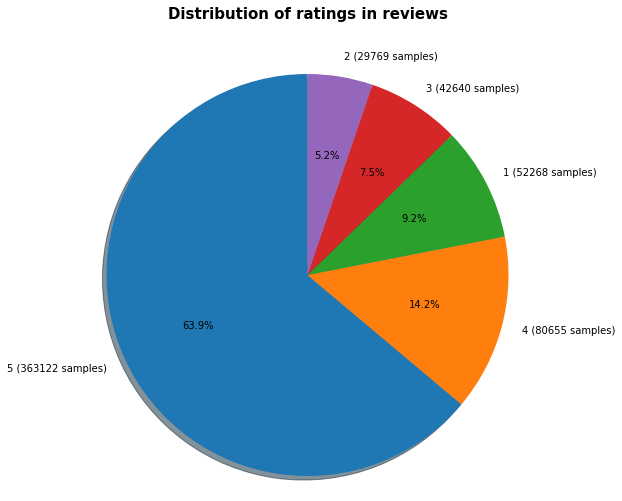

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Score"].value_counts()[k]} samples)' for k in df['Score'].value_counts().keys()]
sizes = dict(df['Score'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of ratings in reviews",pad=40, fontweight='bold', fontsize=15)
plt.show();

Observation:  
1. **~78 percent** of the reviews in the dataset are **positive reviews** having ratings >3 (4 and 5)  
2. **~14 percent** of the reviews in the dataset are **negative reviews** having ratings <3 (1 and 2)  
3. Remaining **~8 percent** reviews have a rating of 3.
4. Since a major portion of the reviews are positive, we can say that most of the users have a good experience with their purchases.

# Data Cleaning
## Check and Delete Duplicate Reviews

In [ ]:
mask_duplicated_reviews = df.duplicated(subset=["UserId","Time","Text"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100

x = PrettyTable()
x.field_names = ["","Count","Percentage of Total"]
x.add_rows([
    ["Duplicate Reviews", count_duplicated_reviews[True], perc_duplicated_reviews[True]],
    ["Original Reviews", count_duplicated_reviews[False], perc_duplicated_reviews[False]],
])
print(x)

+-------------------+--------+---------------------+
|                   | Count  | Percentage of Total |
+-------------------+--------+---------------------+
| Duplicate Reviews | 174562 |  30.70820154313278  |
|  Original Reviews | 393892 |  69.29179845686723  |
+-------------------+--------+---------------------+


### Observation:
* We have about 1.75 lakh reviews(~30% of total reviews) which are duplicated across product variants. Basically reviews by the same user at the same time with same review text.

### Update dataframe to include only original(non-duplicated) reviews (Discarding Duplicated Reviews)

In [ ]:
df = df[~mask_duplicated_reviews]

print(f"Updated No. of Datapoints : {df.shape[0]}")

Updated No. of Datapoints : 393892


## Check and Remove 3 Star(Neutral) Reviews

### Count and Proportion of 3 star reviews

In [ ]:
print(f"{df[df['Score']==3].shape[0]}/{df.shape[0]} ({round((df[df['Score']==3].shape[0]/df.shape[0])*100,2)}% of the total R)")

29768/393892 (7.56% of the total Reviews are of Rating 3 )


> **Recall we have the task of buiding a model which will tag an unseen review as positive or negative. If the scores were between 1 and 10(inclusive), we could have assigned the class label as 'Negative' for reviews with scores [1,2,3,4,5] and 'Positive' for reviews with scores [6,7,8,9,10]. But here since we have scores between 1 and 5(inclusive), we don't have an option to divide the scores in two equal classes. If we were to do that either all the reviews with score of 3 had to be discarded(then reviews with scores [1,2] would fall in 'Negative' class and [4,5] would fall in 'Positive' class) or we could take a decision to either include score '3' reviews in either 'Negative' or 'Positive' Class. Or we could make this a Multiclass Classification Problem (Negative, Neutral and Positive) instead of the current Binary Classification Problem (not expected).**

### Peak the datapoints having a 'Score' of 3

In [ ]:
with pd.option_context('display.max_colwidth', -1):
    display(df[df["Score"]==3].head(10))

### Observations:
* For reviews with index 83 and 84, it talks about how the dog food is great and liked by the dog, but it has a side effect of itching with it. Now this may be not be observed by all the users and here in this case we may conclude that the dog may be allergic with an ingredient that goes into the product. Type - **Case Specific**
* For review with index 78, the customer talks about how the product doesnt taste great in hot weather. Type - **Situational**
* For reviews with index 60 and 68, the main concern is about the price of the product which is kind of a secondary aspect about the product. Type - **Price Concern**
* For reviews with index 45, 47, 106, there is something wrong with respect to the product which may be termed as a negative review. Type - **Negative Review**
* For reviews with index 49, 53, Expectation of the user with respect to taste, health, quality were not met by the product which again may be termed as a negative review. Type - **Negative Review**

> * Since we have a mix of Negative Reviews as well as Neutral Reviews, we can't assign them to 'Negative' Class. That leaves us with the option of discarding all the reviews having a Score of 3.


### Discard all reviews having a Score of 3

In [ ]:
print(f"No. of Datapoints BEFORE discarding : {df.shape[0]}")

df = df[df["Score"]!=3]

print(f"No. of Datapoints AFTER discarding : {df.shape[0]}")


## Discarding reviews having inconsistencies

### Helpfulness numerator should not exceed Helpfulness denominator

In [ ]:
df[df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"]]

### Observations:
* There are two datapoints matching this criteria, discarding them.

In [ ]:
print(f"No. of Datapoints BEFORE discarding : {df.shape[0]}")

df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]]

print(f"No. of Datapoints AFTER discarding : {df.shape[0]}")


# Feature Engineering 1

### Lets replace HelpfulnessNumerator and HelpfulnessDenominator Feature into one feature indicating the HelpfulnessPercentage

In [ ]:
%%time
df["Helpfulness_Perc"] = df[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
df = df.drop(["HelpfulnessNumerator","HelpfulnessDenominator"], axis=1)
df.head()

In [ ]:
plt.figure(figsize=(18,7))
sns.histplot(data=df["Helpfulness_Perc"], bins=50)
plt.title("Distribution of Helpfulness_Percentage",fontweight='bold', fontsize=15)
plt.xticks(range(0,100,2), rotation=45)
plt.show();

### Lets create a new feature off of 'Helpfulness_Perc' which will be an indicator of helpfulness basis the helpfulness percentage. This will be a 4-class feature.  

In [ ]:
x = PrettyTable()
x.field_names = ["Condition", "Class"]
x.add_rows([
    ["Helpfulness_Perc >= 75", "Useful"],
    ["40 < Helpfulness_Perc < 75","Intermediate"],
    ["0 < Helpfulness_Perc <= 40","Not Useful"],
    ["Helpfulness_Perc = 0","Not Available"],
])
print(x)

In [ ]:
# Assigning Helpfulness indicator
df.loc[df["Helpfulness_Perc"] >= 75, 'Helpfulness_indicator'] = 'Useful'
df.loc[(df["Helpfulness_Perc"] > 40) & (df["Helpfulness_Perc"] < 75), 'Helpfulness_indicator'] = 'Intermediate'
df.loc[(df["Helpfulness_Perc"] > 0) & (df["Helpfulness_Perc"] <= 40), 'Helpfulness_indicator'] = 'Not Useful'
df.loc[df["Helpfulness_Perc"] == 0, 'Helpfulness_indicator'] = 'Not Available'

df = df.drop(["Helpfulness_Perc"], axis=1)

df.head()

In [ ]:
plt.figure(figsize=(12,7))
sns.countplot(df['Helpfulness_indicator'], palette=sns.color_palette("RdYlGn", 4), order=["Not Available","Not Useful","Intermediate","Useful"])
plt.title("Distribution of Helpfulness_indicator",fontweight='bold', fontsize=15)
plt.xlabel("Helpfulness_indicator")
plt.ylabel("Number of reviews corresponding to each of 4 Helpfulness_indicator")
plt.show();
print('\n')
print(df['Helpfulness_indicator'].value_counts()[[0,3,2,1]]);

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Helpfulness_indicator"].value_counts()[k]} samples)' for k in df['Helpfulness_indicator'].value_counts().keys()]
sizes = dict(df['Helpfulness_indicator'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("All Samples", pad=40,fontweight='bold', fontsize=15)
plt.show();

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Helpfulness_indicator"].value_counts()[k]} samples)' for k in ['Useful','Not Useful']]
sizes = dict(df['Helpfulness_indicator'].value_counts())
sizes.pop('Not Available')
sizes.pop('Intermediate')
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Excluding 'Not Available' and 'Intermediate' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

### Observations:
* Ignoring 'Not Available' and 'Intermediate'(Since we want to be sure of the fact that it is useful/non-useful) Datapoints, if we look at the count of 'Useful' and 'Not Useful' we can see that **94.3%** of reviews are Useful and **5.7%** are Not Useful

### Assigning 'Sentiment_Class' Feature

Score > 3 (4,5) -> Positive  
Score < 3 (1,2) -> Negative  

In [ ]:
df.loc[df["Score"] > 3, 'Sentiment_Class'] = 'Positive'
df.loc[df["Score"] < 3, 'Sentiment_Class'] = 'Negative'

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Sentiment_Class"].value_counts()[k]} samples)' for k in df['Sentiment_Class'].value_counts().keys()]
sizes = dict(df['Sentiment_Class'].value_counts())
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Count of 'Positive' and 'Negative' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

### Observations:
* **Positive reviews are more common than negative reviews.**

### Assigning 'Review_Word_Count' Feature


In [ ]:
%%time
df["Review_Word_Count"] = df["Text"].apply(lambda x: len(x.split()))
with pd.option_context('display.max_colwidth', -1):
    display(df.head(1))

# EDA 2 (After Data Cleaning, FE1)

## What is the distribution of useful and non-useful reviews in each of the set of Positive and Negative Reviews.

In [ ]:
df_temp = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate")]
df_temp_1 = df_temp["Helpfulness_indicator"].groupby(df_temp["Sentiment_Class"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_temp_1, x="Sentiment_Class", y="Percentage", hue="Helpfulness_indicator", hue_order=["Not Useful","Useful"], palette=sns.color_palette("RdYlGn", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
print('\n')
df_temp_1

### Observations
* **If we just look at Negative Reviews, a little more than quarter of the customers finding them non-useful(~27%)**.
    1. Some cases of Negative Reviews being non-helpful : This could be for reviews which talks about some situational things which the customers who are reading them may not be concerned about. (for eg. a review which talks about how pricey the product is (this review will be negative since the rating given was less than 3). But the customer reading them is willing to pay a premium for good quality, taste. So in such cases, they find it not useful.)
    2. Here, as we have seen earlier also reviews belonging to such cases are prevalent in our dataset.
* **If we just look at Positive Reviews, there are very very few customers finding them non-useful(~2%)**. 
    1. Some cases of Positive Reviews being non-helpful : This could be for reviews which doesn't explain in length/detail as to why the product is good(for example - "good", "best"). Or some reviews which may have been paid for by the brand itself, as we call paid reviews, which the customers prompty recognized by the tone of it.
    2. So we can safely say that our dataset doesn't have much - such kind of reviews.
* **So if we look at the above graph collectively, Most of the Customers find both Negative and Positive reviews useful (>94%) (presumably to make their purchase decisions).**

## What is the distribution of Positive and Negative Reviews in each of the set of useful and non-useful reviews

In [ ]:
df_temp = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate")]
df_temp_1 = df_temp["Sentiment_Class"].groupby(df_temp["Helpfulness_indicator"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100 
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_temp_1, x="Helpfulness_indicator", y="Percentage", hue="Sentiment_Class", hue_order=["Negative","Positive"], palette=sns.color_palette("RdYlGn", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
df_temp_1

### Observations:
* If we just look at the reviews which are **non-useful**, we can see that the share of **negative** reviews are far more than the positive reviews. So, Users find the ***negative reviews to be less helpful*** in general.
* If we just look at the reviews which are **useful**, we can see that the share of **positive** reviews are far more than the negative reviews. So, Users find the ***positive reviews to be more helpful*** in general.

## Review Length vs. Review Usefulness

In [ ]:
temp_df_useful_nonuseful = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate")]
plt.figure(figsize=(20,8))
sns.violinplot(x='Review_Word_Count', y='Helpfulness_indicator', data=temp_df_useful_nonuseful);

### Observation:
* Since many outliers are there i.e. reviews with too many words are present, so in order to capture better co-relation between review length and ratings, we can consider reviews with 500 words or less.

In [ ]:
temp_df_useful_nonuseful_500wc = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate") & (df["Review_Word_Count"]<500)]
plt.figure(figsize=(20,8))
sns.violinplot(x='Review_Word_Count', y='Helpfulness_indicator', data=temp_df_useful_nonuseful_500wc, orient="h")
plt.xticks(range(0,500,10), rotation=45)
plt.show()
temp_df_useful_nonuseful_500wc["Review_Word_Count"].groupby(temp_df_useful_nonuseful_500wc["Helpfulness_indicator"]).describe()

### Observation:
* Useful reviews are generally lengthier than non-useful reviews in terms of mean, median(50%), max, etc. (**Helpful reviews are longer**)
* Helpful reviews have a higher median word count(63 words) as compared to non-helpful's (56 words)
* There is a high concentration of reviews which are having a word count in the neighbourhood of 30.
* Distribution of both useful and non-useful reviews are more or less the same; follows the log-normal distribution which is inline with most human behaviours.

## Review Length vs. Review Sentiment

In [ ]:
plt.figure(figsize=(20,8))
sns.violinplot(x='Review_Word_Count', y='Sentiment_Class', data=temp_df_useful_nonuseful);

### Observation:
* Since many outliers are there i.e. reviews with too many words are present, so in order to capture better co-relation between review length and ratings, we can consider reviews with 500 words or less.
* The max length of a Positive review is much higher(\~2500)  as compared to Negative Review(\~1600)

In [ ]:
plt.figure(figsize=(20,8))
sns.violinplot(x='Review_Word_Count', y='Sentiment_Class', data=temp_df_useful_nonuseful_500wc, orient="h")
plt.xticks(range(0,350,10), rotation=45)
plt.show()
temp_df_useful_nonuseful_500wc["Review_Word_Count"].groupby(temp_df_useful_nonuseful_500wc["Sentiment_Class"]).describe()

### Observation:
* Negative reviews are generally lengthier than Positive reviews in terms of mean, 25th percentile, median(50th percentile), 75th percentile, etc. (**Positive Reviews are shorter**)
* The standard deviation is higher in case of Positive Reviews.

## Wordcloud for Reviews.
### Plotting word cloud to understand the top words that have occured most frequently in the reviews.

There are 155828447 words in the combination of all review.


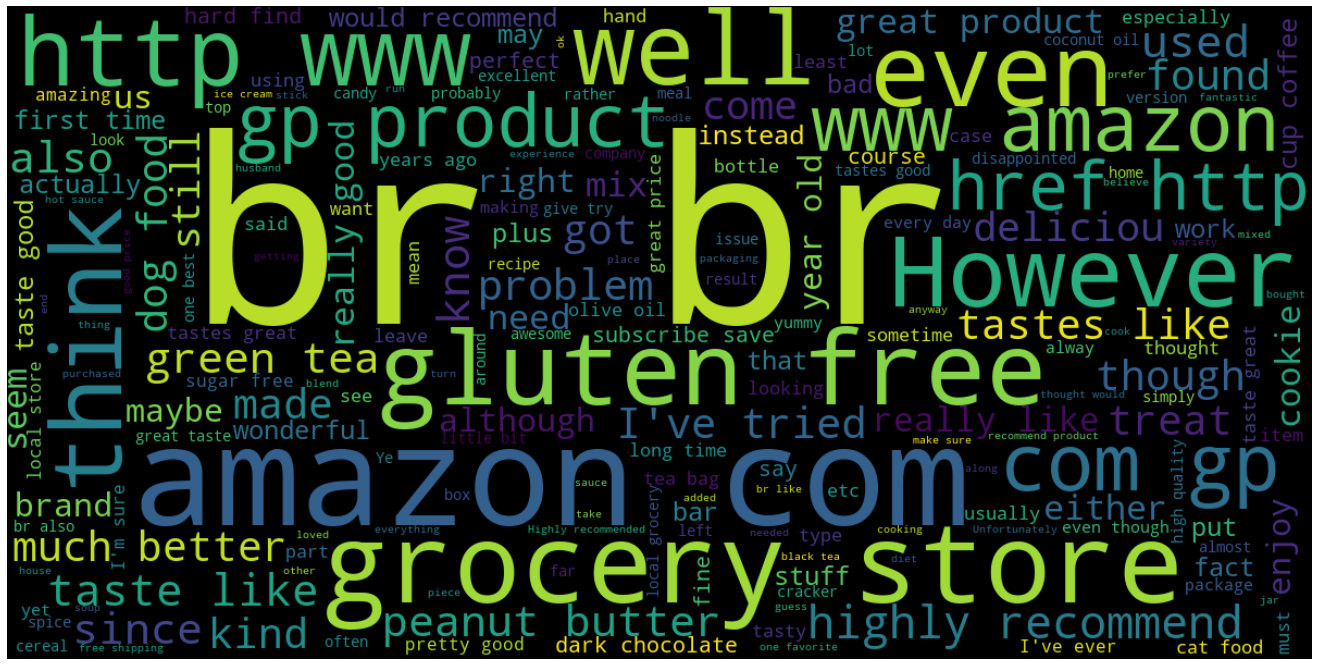

CPU times: user 1min 35s, sys: 3.12 s, total: 1min 38s
Wall time: 1min 38s


In [ ]:
%%time


text = " ".join(review for review in df["Text"])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="black", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:
* There is a high frequency(big size among the word counts) of occurance of the word "br" in the reviews. Since it occurs in the html tags indicating breaks : ```<br> </br>```, we can presume the presence of other html tags as well. So in the text preprocessing step, we need to remove all the html related text/tags.

### Plotting word cloud to understand the top words that have occured most frequently in the POSITIVE reviews.

There are 129114833 words in the combination of all positive reviews.


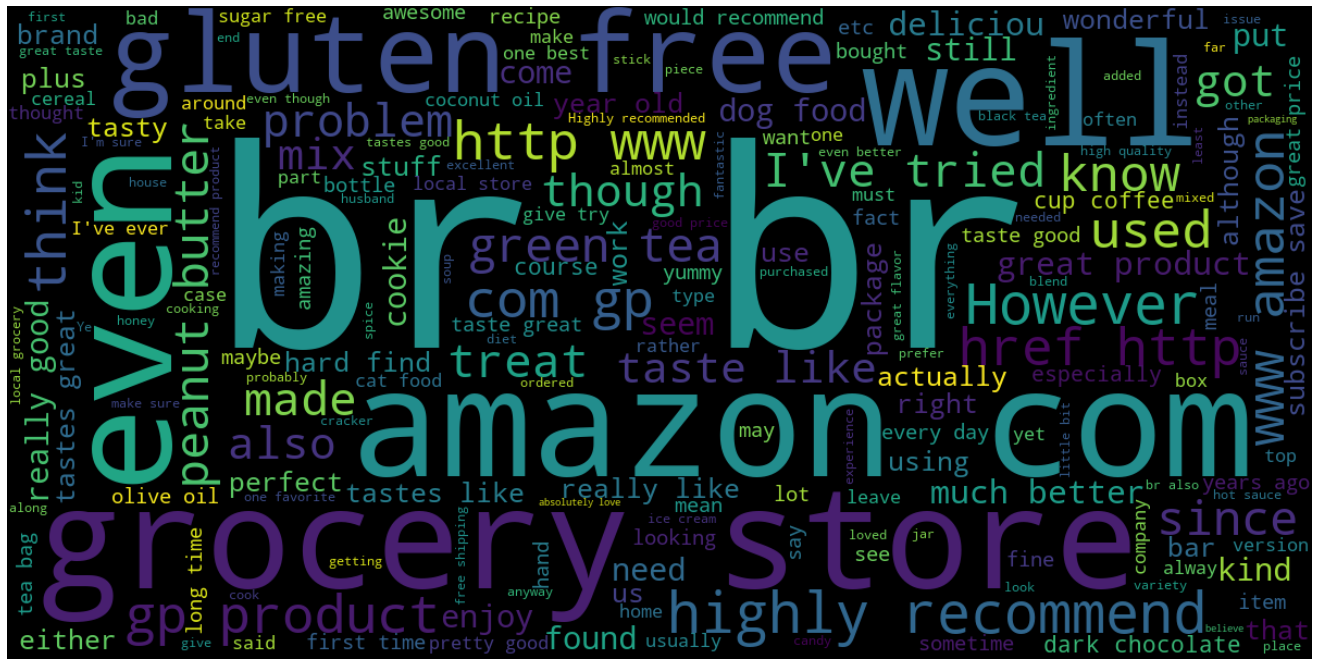

CPU times: user 1min 26s, sys: 2.77 s, total: 1min 29s
Wall time: 1min 33s


In [ ]:
%%time
df_positive = df[df["Sentiment_Class"] == "Positive"]
text = " ".join(review for review in df_positive["Text"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="black", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:
* We can see the presence of words with positive sentiments such as:  
    * excellent
    * perfect
    * good
    * wonderful
    * amazing
    * best
    * love
    * tasty

### Plotting word cloud to understand the top words that have occured most frequently in the NEGATIVE reviews.

There are 26713613 words in the combination of all negative reviews.


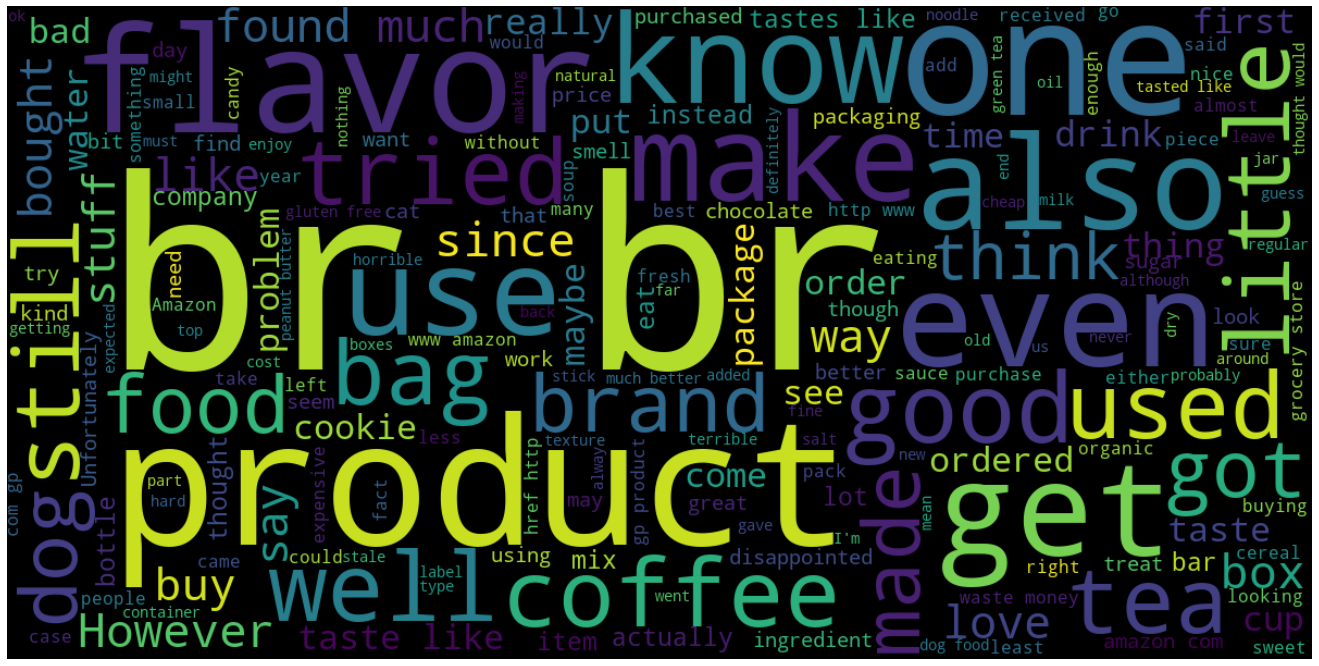

CPU times: user 21.6 s, sys: 1.6 s, total: 23.3 s
Wall time: 23.3 s


In [ ]:
%%time
df_negative = df[df["Sentiment_Class"] == "Negative"]
text = " ".join(review for review in df_negative["Text"])
print ("There are {} words in the combination of all negative reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="black", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:
* We can see the presence of words with negative sentiments such as:  
    * Unfortunately
    * stale
    * horrible
    * disappointed
    * terrible
    * bad

## EDA Observations (Consolidated):
1. Positive reviews are more common than negative reviews.
2. If we just look at Negative Reviews, a little more than quarter of the customers finding them non-useful(~27%)
3. If we just look at Positive Reviews, there are very very few customers finding them non-useful(~2%)
4. Most of the Customers find both Negative and Positive reviews useful (>94%) (presumably to make their purchase decisions).
5. negative reviews are less helpful
6. positive reviews are more helpful
7. Helpful reviews are longer
8. Positive Reviews are shorter

## EDA Conclusion:
* Positive reviews are common
* Positive reviews are shorter (in terms of word count)
* Helpful reviews are longer.
* Despite being shorter, Positive reviews are found to be more helpful.


# Data Preprocessing

## Text Preprocessing

### Remove html tags

In [ ]:
import re

# Ref: https://stackoverflow.com/a/12982689
def remove_html_tags(sentence):
    pattern = re.compile("<.*?>") # Match any text wrapped with < and > along with the < and >
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

sentence = "<a href='sample.com'> <b> Click </b> here <br/> </a>"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_html_tags(sentence)}")

Sample
Before: <a href='sample.com'> <b> Click </b> here <br/> </a>
After: Click  here


### Remove URLs (starting with 'http' as well as 'www')

In [ ]:
# Ref: https://stackoverflow.com/a/12982689
def remove_urls(sentence):
    http_pattern = re.compile(r"http\S+") # Matches all words starting with 'http' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(http_pattern,'',sentence).strip()
    www_pattern = re.compile(r"www\S+") # Matches all words starting with 'www' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(www_pattern,'',cleaned_sentence)
    return cleaned_sentence

sentence = """url starting with http s : https://www.google.com/search?client=ubuntu&channel=fs&q=google+drive+storage+plans&ie=utf-8&oe=utf-8
url starting with http : http://google.com
url starting with www : www.google.co.in"""
print("Sample\n")
print(f"Before:\n {sentence}\n")
print(f"After:\n {remove_urls(sentence)}")

Sample

Before:
 url starting with http s : https://www.google.com/search?client=ubuntu&channel=fs&q=google+drive+storage+plans&ie=utf-8&oe=utf-8
url starting with http : http://google.com
url starting with www : www.google.co.in

After:
 url starting with http s : 
url starting with http : 
url starting with www : 


### Removing HTML Entities like &nbsp, &#60, a&#771('a' with a bar on top), etc.

In [ ]:
# Ref: https://www.w3schools.com/html/html_entities.asp
# Ref: https://stackoverflow.com/a/12982689
def remove_html_entities(sentence):
    pattern = re.compile("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}")
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

sentence = "&nbsp, &#60, a&#771"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_html_entities(sentence)}")

Sample
Before: &nbsp, &#60, a&#771
After: , , a


### Remove words with numbers 

In [ ]:
# Ref: https://stackoverflow.com/a/18082370/4084039
def remove_words_with_numbers(sentence):
    pattern = re.compile("\S*\d\S*") # Match a word starting with 0 or more occurances of a non whitespace character, then a digit followed by 0 or more occurances of a non whitespace character
    cleaned_text = re.sub(pattern,"", sentence).strip()
    return cleaned_text

sentence = "  The5 number is removed removed55 "
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_words_with_numbers(sentence)}")

Sample
Before:   The5 number is removed removed55 
After: number is removed


### Remove words with 3 or more repeated characters (words like 'happpyyy')

In [ ]:
# Ref : https://stackoverflow.com/a/37013006
def remove_words_with_repeated_characters(sentence): 
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    cleaned_text  = re.sub(pattern,' ',sentence)
    return (cleaned_text)

sentence = "This looks soooooooo good! I am so happpyyy aa aaa aaaa"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_words_with_repeated_characters(sentence)}")

Sample
Before: This looks soooooooo good! I am so happpyyy aa aaa aaaa
After: This looks  good! I am so  aa  


### Expand the common english contradictions

In [ ]:
# Ref : https://stackoverflow.com/a/47091490
def expand_eng_contradictions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sentence = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it."
print("Sample")
print(f"Before: {sentence}")
print(f"After: {expand_eng_contradictions(sentence)}")

Sample
Before: Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it.
After: Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it.


### Remove Special Characters and Punctuations

In [ ]:
# Ref: https://stackoverflow.com/a/5843547/4084039
def remove_special_characters_punctuations(sentence):
    pattern = re.compile("[^a-zA-Z]+") # match a single character not present in the set (basically anything other than a-z and A-Z)
    cleaned_text  = re.sub(pattern,' ',sentence).strip()
    return cleaned_text

sentence = "fsd*?~,,,( garr1rgggv.)#! a"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_special_characters_punctuations(sentence)}")

Sample
Before: fsd*?~,,,( garr1rgggv.)#! a
After: fsd garr rgggv a


## Stemming
**Stemming is basically removing the suffix from a word and reduce it to its root word.**

Example 1: “Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”.  
Example 2: "Tradition" and "Traditional" have the same stem word - "tradit"

[Ref](https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e#:~:text=Stemming%20is%20basically%20removing%20the%20suffix%20from%20a%20word,it%20to%20its%20root%20word.&text=We%20uses%20these%20suffix%20to,to%20all%20its%20inflected%20variants.)

### Porter Stemmer
* This is one of the most common and gentle stemmer, Its fast but not very precise.  

In [ ]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
print(f"was -> {porter.stem('was')}")
print(f"flying -> {porter.stem('flying')}")
print(f"delicious -> {porter.stem('delicious')}")
print(f"caring -> {porter.stem('caring')}")
print(f"bought -> {porter.stem('bought')}")

was -> wa
flying -> fli
delicious -> delici
caring -> care
bought -> bought


* Look at the input and you can see we are passing “was” and getting “wa” as output. This is something which should be considered under less precise algorithm. To increase the precision another algorithm came which was SnowBall Stemmer.

### Snowball Stemmer
* There were some improvements done on Porter Stemmer which made it more precise over large data-sets.  
* There is an impotant feature added to this algorithm which was excluding Stop Word Stemming.  

In [ ]:
from nltk.stem.snowball import SnowballStemmer

snowball = SnowballStemmer('english')
print(f"was -> {snowball.stem('was')}")
print(f"flying -> {snowball.stem('flying')}")
print(f"delicious -> {snowball.stem('delicious')}")
print(f"caring -> {snowball.stem('caring')}")
print(f"bought -> {snowball.stem('bought')}")

was -> was
flying -> fli
delicious -> delici
caring -> care
bought -> bought


Due to this feature we observed difference in “was” input.  

### Lancaster Stemmmer
* It is very aggressive algorithm.  
* It will hugely trim down your working set, this statement itself has pros and cons, sometime you many want this in your datasets but maximum time you will be avoiding it.

In [ ]:
from nltk.stem.lancaster import LancasterStemmer

lancaster = LancasterStemmer()
print(f"was -> {lancaster.stem('was')}")
print(f"flying -> {lancaster.stem('flying')}")
print(f"delicious -> {lancaster.stem('delicious')}")
print(f"caring -> {lancaster.stem('caring')}")
print(f"bought -> {lancaster.stem('bought')}")

was -> was
flying -> fly
delicious -> delicy
caring -> car
bought -> bought


* Aggression can be observed by “Caring” input, It was converted to “car” which is altogether a different word in English dictionary.

## Stemming Conclusion
* Out of the 3 stemmers that we have seen, snowball stemmer seems to be the good one to go ahead with in our usecase

## Lemmatization

[Ref](https://medium.com/@tusharsri/lemmatization-af85aa3e5a86)

**Inflection** is a process of word formation, in which a word is modified to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, mood, animacy, and definiteness.  

* Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word’s lemma, or dictionary form.  
* for example, run, runs, ran and running are forms of the same set of words that are related through inflection, with run as the lemma.  

What is the different between Stemming and Lemmatization?  
* Unlike Stemming, Lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.  

Why should we need Lemmatization when we have Stemming?  
1. The purpose of both stemming and lemmatization is to reduce morphological variation or to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.  
2. A Stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.  
3. In lemmatisation, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.  


### Lemmatization using NLTK's Wordnet Lemmatizer

In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

lemmatizer = WordNetLemmatizer()

sentence = "the boy's cars are different colors, best go went gone going run runs ran and running"

word_list = word_tokenize(sentence)
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
# print(sentence)
# print(lemmatized_output)
print(f"Sample Sentence: {sentence}")
print(f"After Stemming: {lemmatized_output}")

Sample Sentence: the boy's cars are different colors, best go went gone going run runs ran and running
After Stemming: the boy 's car are different color , best go went gone going run run ran and running


### Observations:
1. Cars was converted to root form(singular) : car
2. Colors was converted to root form(singular) : color
3. **Best was not converted to root form : good**
4. **go, went, gone, going were not converted to their root form : go**
5. run and runs came into same root word but **ran and running didnt**

### Conclusion:  
WordNet was only able to remove the suffix in cases applicable

### Lemmatization using Spacy

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

sentence = "the boy's cars are different colors, best go went gone going run runs ran and running"

doc = nlp(sentence)

print(f"Sample Sentence: {sentence}")
print(f"After Lemmatization: {' '.join([token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_ for token in doc])}")

Sample Sentence: the boy's cars are different colors, best go went gone going run runs ran and running
After Lemmatization: the boy 's car be different color , best go go go go run run run and run


### Observations:
1. Cars was converted to root form(singular) : car
2. Colors was converted to root form(singular) : color
3. Best was converted to root form : good
4. go, went, gone, going were not converted to their root form : go
5. run, runs, ran, running came into same root word : run

### Conclusion:
Shortcomings of wordnet lemmatizer were taken care by spacy.

### Check if stemming followed by lemmatization yields better results for some test words compared to just stemming

### just stemming

In [ ]:
def only_stem_print(word):
    stem=snowball.stem(word)
    print(f"{word} -> {stem}")

only_stem_print('was')
only_stem_print('flying')
only_stem_print('flew')
only_stem_print('flown')
only_stem_print('delicious')
only_stem_print('delicacy')
only_stem_print('caring')
only_stem_print('bought')
only_stem_print('tasty')
only_stem_print('taste')
only_stem_print('cry')
only_stem_print('crying')

def only_stem(word):
    return snowball.stem(word)

was -> was
flying -> fli
flew -> flew
flown -> flown
delicious -> delici
delicacy -> delicaci
caring -> care
bought -> bought
tasty -> tasti
taste -> tast
cry -> cri
crying -> cri


### just lemmatization

In [ ]:
def only_lemmatize_print(word):
    lemma=nlp(word)[0].lemma_
    lemma = lemma.lower() if lemma != '-PRON-' else word.lower()
    print(f"{word} -> {lemma}")

only_lemmatize_print('was')
only_lemmatize_print('flying')
only_lemmatize_print('flew')
only_lemmatize_print('flown')
only_lemmatize_print('delicious')
only_lemmatize_print('delicacy')
only_lemmatize_print('caring')
only_lemmatize_print('bought')
only_lemmatize_print('tasty')
only_lemmatize_print('taste')
only_lemmatize_print('cry')
only_lemmatize_print('crying')
only_lemmatize_print('she')

def only_lemmatize(word):
    lemma = nlp(word)[0].lemma_
    lemma = lemma.lower() if lemma != '-PRON-' else word.lower()
    return lemma

was -> be
flying -> fly
flew -> fly
flown -> fly
delicious -> delicious
delicacy -> delicacy
caring -> care
bought -> buy
tasty -> tasty
taste -> taste
cry -> cry
crying -> cry
she -> she


### stemming followed by lemmatization

In [ ]:
def lemmatize_then_stem_print(word):
    lemma=nlp(word)[0].lemma_
    stem=snowball.stem(lemma)
    print(f"{word} -> {lemma} -> {stem}")


lemmatize_then_stem_print('was')
lemmatize_then_stem_print('flying')
lemmatize_then_stem_print('flew')
lemmatize_then_stem_print('flown')
lemmatize_then_stem_print('delicious')
lemmatize_then_stem_print('delicacy')
lemmatize_then_stem_print('caring')
lemmatize_then_stem_print('bought')
lemmatize_then_stem_print('tasty')
lemmatize_then_stem_print('taste')
lemmatize_then_stem_print('cry')
lemmatize_then_stem_print('crying')

def lemmatize_then_stem(word):
    lemma=nlp(word)[0].lemma_
    stem=snowball.stem(lemma)
    return stem

was -> be -> be
flying -> fly -> fli
flew -> fly -> fli
flown -> fly -> fli
delicious -> delicious -> delici
delicacy -> delicacy -> delicaci
caring -> care -> care
bought -> buy -> buy
tasty -> tasty -> tasti
taste -> taste -> tast
cry -> cry -> cri
crying -> cry -> cri


## Applying all the Text Preprocessing steps on the review data without stemming.

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
%%time
from tqdm.contrib.concurrent import process_map
from nltk.corpus import stopwords

default_stopwords=set(stopwords.words('english'))

preprocessed_reviews=[] # store all the preprocessed reviews

def process_review(idx, remove_stopwords=False):
    review = df.at[idx, 'Text']
    
    filtered_sentence=[]
    
    review=remove_html_tags(review)
    review=remove_urls(review)
    review=remove_html_entities(review)
    review=remove_words_with_numbers(review)
    review=remove_words_with_repeated_characters(review)
    review=expand_eng_contradictions(review)
    review=remove_special_characters_punctuations(review)
    
    for word in review.split(): # Tokenizing a text or review
        
        if((word.isalpha()) and (len(word)> 2)):
            word_lower = word.lower()
            
            # Removing Stopwords
            if((not remove_stopwords) or ((remove_stopwords) and (word_lower not in default_stopwords))):
                filtered_sentence.append(word_lower)
                
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    return idx, str1.strip()


for idx, processed_review in process_map(process_review, df.index, max_workers=4):
    preprocessed_reviews.append(processed_review)
    

preprocessed_reviews_words = []
for review in preprocessed_reviews:
    for word in review.split():
        preprocessed_reviews_words.append(word)
print(f"Count of Distinct words in corpus without stemming:{len(set(preprocessed_reviews_words))}");

  0%|          | 0/364122 [00:00<?, ?it/s]

Count of Distinct words in corpus without stemming:116736
CPU times: user 1min 57s, sys: 21.5 s, total: 2min 18s
Wall time: 3min 38s


## Applying all the Text Preprocessing steps on the review data with stemming.

In [ ]:
%%time
preprocessed_reviews=[] # store all the preprocessed reviews

def process_review(idx, remove_stopwords=False):
    review = df.at[idx, 'Text']
    
    filtered_sentence=[]
    
    review=remove_html_tags(review)
    review=remove_urls(review)
    review=remove_html_entities(review)
    review=remove_words_with_numbers(review)
    review=remove_words_with_repeated_characters(review)
    review=expand_eng_contradictions(review)
    review=remove_special_characters_punctuations(review)
    
    for word in review.split(): # Tokenizing a text or review
        
        if((word.isalpha()) and (len(word)> 2)):
            word_lower = word.lower()
            
            # Removing Stopwords
            if((not remove_stopwords) or ((remove_stopwords) and (word_lower not in default_stopwords))):
                s=(only_stem(word_lower)) #Stemming the word using SnowBall Stemmer
                filtered_sentence.append(s)
                
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    return idx, str1.strip()


for idx, processed_review in process_map(process_review, df.index, max_workers=4):
    preprocessed_reviews.append(processed_review)
#     df.at[idx, 'CleanedText'] = processed_review
    

preprocessed_reviews_words = []
for review in preprocessed_reviews:
    for word in review.split():
        preprocessed_reviews_words.append(word)
print(f"Count of Distinct words in corpus with Stemming:{len(set(preprocessed_reviews_words))}");

  0%|          | 0/364122 [00:00<?, ?it/s]

Count of Distinct words in corpus with Stemming:86137
CPU times: user 2min 35s, sys: 24.5 s, total: 2min 59s
Wall time: 10min 17s


## Applying all the Text Preprocessing steps on the review data with only lemmatization.

In [ ]:
%%time
preprocessed_reviews=[] # store all the preprocessed reviews

def process_review(idx, remove_stopwords=False):
    review = df.at[idx, 'Text']
    
    filtered_sentence=[]
    
    review=remove_html_tags(review)
    review=remove_urls(review)
    review=remove_html_entities(review)
    review=remove_words_with_numbers(review)
    review=remove_words_with_repeated_characters(review)
    review=expand_eng_contradictions(review)
    review=remove_special_characters_punctuations(review)
    
    for word in review.split(): # Tokenizing a text or review
        
        if((word.isalpha()) and (len(word)> 2)):
            word_lower = word.lower()
            
            # Removing Stopwords
            if((not remove_stopwords) or ((remove_stopwords) and (word_lower not in default_stopwords))):
                s=(only_lemmatize(word.lower()))
                filtered_sentence.append(s)
                
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    return idx, str1.strip()


for idx, processed_review in process_map(process_review, df.index, max_workers=4):
    preprocessed_reviews.append(processed_review)
    df.at[idx, 'CleanedText'] = processed_review
    

preprocessed_reviews_words = []
for review in preprocessed_reviews:
    for word in review.split():
        preprocessed_reviews_words.append(word)
print(f"Count of Distinct words in corpus with Stemming:{len(set(preprocessed_reviews_words))}");

## Serialize the dataframe to a file

In [ ]:
with pd.option_context('display.max_colwidth', -1):
    display(df.head())

In [ ]:
%%time
df.to_csv("./cleaned_df_amazon_fine_food_reviews.csv")

In [ ]:
%%time
df.to_pickle("./cleaned_df_amazon_fine_food_reviews.pkl")